In [1]:
library(ggplot2)
library(dplyr)
library(tidyverse)
options(warn=-1)
library(MASS)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.1.8
✔ purrr     1.0.1     ✔ tidyr     1.3.0
✔ readr     2.1.4     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select




In [2]:
dffull = read.csv("Bike-Sharing-Dataset//hour.csv", header = TRUE)
dffull$rawtemp = dffull$temp*47-8 # converting temp to raw form
dffull$rawatemp = dffull$atemp*66-16 # converting atemp to raw
dffull$rawhum = dffull$hum*100 # converting hum to raw form
dffull$rawwindspeed = dffull$windspeed*67 # converting windspeed to raw form 

# Removing variables I don't care about
dflessvar <- subset(dffull, select = -c(instant, dteday,temp, atemp, hum, windspeed, rawatemp, workingday))
  
# converting some to factors
# columns that should be factors
cols <- c("season", "mnth", "hr","holiday","weekday","weathersit")
dflessvar[,cols] <- data.frame(lapply(dflessvar[cols], as.factor))

# setting levels of factors
levels(dflessvar$season) <- c("winter", "spring", "summer", "fall")
levels(dflessvar$mnth) <- c("Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec")
levels(dflessvar$holiday) <- c("Not Holiday", "Holiday")
levels(dflessvar$weekday) <- c("Sun","Mon","Tues","Wed","Thurs","Fri","Sat")
#levels(dflessvar$workingday) <- c("Not working day","Working day")
levels(dflessvar$weathersit) <- c("Clear","Misty","Light precip", "heavy precip")

In winters, the expected number of bikers would be less between the hours 1am-4am in the winter months and hence the variance will also be less, in contrast, the expected number of bikers would be more in summer months and hence the variance will be higher. We show this with the code below.

### Create new data frame with rows between hours 1 and 4 for Dec, Jan, Feb to show non-constant variance across data

In [3]:
temp1 <- dffull %>%
  filter(hr >= 1 & hr <= 4 & mnth %in% c(12, 1, 2))

# Calculate mean and variance of cnt variable for new data frame
mean_cnt <- mean(temp1$cnt)
var_cnt <- var(temp1$cnt)

# Print the results
cat("Mean (1am - 4am in Dec, Jan, Feb):", mean_cnt, "\n")
cat("Variance (1am - 4am in Dec, Jan, Feb):", var_cnt, "\n")

Mean (1am - 4am in Dec, Jan, Feb): 12.10479 
Variance (1am - 4am in Dec, Jan, Feb): 284.7236 


### Create new data frame with rows between hours 6-9 for Apr, May, June to show non-constant variance to show non-constant variance across data

In [4]:
temp2 <- dffull %>%
  filter(hr >= 6 & hr <= 9 & mnth %in% c(4, 5, 6))

# Calculate mean and variance of cnt variable for new data frame
mean_cnt <- mean(temp2$cnt)
var_cnt <- var(temp2$cnt)

# Print the results
cat("Mean of cnt for hours 6-9 in Apr, May, Jun:", mean_cnt, "\n")
cat("Variance of cnt for hours 6-9 in Apr, May, Jun:", var_cnt, "\n")


Mean of cnt for hours 6-9 in Apr, May, Jun: 238.0165 
Variance of cnt for hours 6-9 in Apr, May, Jun: 32062.56 


Heteroscedasticity refers to a violation of the assumption in the linear model:

$ Y = \beta_{0} + \sum\limits_{j=1} ^ {p} X_{j}\beta_{j} + \epsilon  $

where the variance of the response variable (cnt) is not constant across the range of predictor variables. The most common form of heteroscedasticity in the response variable is that the variance of the response variable may change as the mean of the response variable changes. The estimate for the variance of the slope and variance will be inaccurate. Heteroscedasticity can be detected by examining the scatterplot of the data before performing the regression. We will plot a graph of mean vs variance for thre cnt values for both the years to inspect this.

In [5]:
year_2011 <- subset(dffull, yr == 0)
cnt_summary_2011 <- aggregate(cnt ~ mnth, data = year_2011, FUN = function(x) c(mean = mean(x), var = var(x)))
cnt_summary_2011$mean <- cnt_summary_2011$cnt[,1]
cnt_summary_2011$var <- cnt_summary_2011$cnt[,2]
cnt_summary_2011$yr <- 2011
cnt_summary_2011$yr <- factor(cnt_summary_2011$yr) 
cnt_summary_2011 = cnt_summary_2011[c("mnth", "mean", "var", "yr")]

year_2012 <- subset(dffull, yr == 1)
cnt_summary_2012 <- aggregate(cnt ~ mnth, data = year_2012, FUN = function(x) c(mean = mean(x), var = var(x)))
cnt_summary_2012$mean <- cnt_summary_2012$cnt[,1]
cnt_summary_2012$var <- cnt_summary_2012$cnt[,2]
cnt_summary_2012$yr <- 2012
cnt_summary_2012$yr <- factor(cnt_summary_2012$yr) 
cnt_summary_2012 = cnt_summary_2012[c("mnth", "mean", "var", "yr")]

summary = rbind(cnt_summary_2011, cnt_summary_2012)
summary = summary[c("yr", "mnth", "mean", "var")]

In [6]:
summary

yr,mnth,mean,var
<fct>,<int>,<dbl>,<dbl>
2011,1,55.50727,2363.968
2011,2,74.29122,4048.268
2011,3,87.73288,6221.974
2011,4,131.94715,15056.421
2011,5,182.55511,21431.031
2011,6,199.32222,24050.936
2011,7,189.97446,20977.026
2011,8,186.99179,23089.841
2011,9,177.70990,21731.449


In [7]:
summary$Mean = round(summary$mean, 2)
summary$Var = round(summary$var, 2)
summary = summary[,-c(3,4)]
summary

yr,mnth,Mean,Var
<fct>,<int>,<dbl>,<dbl>
2011,1,55.51,2363.97
2011,2,74.29,4048.27
2011,3,87.73,6221.97
2011,4,131.95,15056.42
2011,5,182.56,21431.03
2011,6,199.32,24050.94
2011,7,189.97,20977.03
2011,8,186.99,23089.84
2011,9,177.71,21731.45


In [8]:
colnames(summary)[1] = "Year"
colnames(summary)[2] = "Month"

In [9]:
colnames(summary)

[1] "Year"  "Month" "Mean"  "Var"

### Table1

In [10]:
# options(repr.plot.width = 12, repr.plot.height = 8)
# ggplot(summary, aes(x = mnth, y = var)) + 
#   geom_line(size = 2, color = "red") + facet_wrap(~yr) +
#   labs(x = "Month", y = "Variance of cnt") +
#   theme(axis.title.x = element_text(size = 11), 
#         axis.title.y = element_text(size = 11), 
#         plot.title = element_text(size = 15, hjust = 0.5),
#         axis.text.y = element_text(size = 7)) +
# scale_x_continuous(breaks = 1:12, labels = 1:12)

options(repr.plot.width = 12, repr.plot.height = 8)

ggplot(summary, aes(x = mnth, y = var)) + 
  geom_line(size = 2, color = "red") + 
  facet_wrap(~yr) +
  labs(x = "Month", y = "Variance of cnt across months") +
  theme(axis.title.x = element_text(size = 11), 
        axis.title.y = element_text(size = 11), 
        plot.title = element_text(size = 15, hjust = 0.5),
        axis.text.y = element_text(size = 7)) +
  scale_x_continuous(breaks = 1:12, labels = 1:12)

ERROR while rich displaying an object: Error in `combine_vars()`:
! At least one layer must contain all faceting variables: `yr`
✖ Plot is missing `yr`
✖ Layer 1 is missing `yr`

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6.

### Figure 1

The plot above clearly shows that the variance varies throughout the year and the assumption of a linear relationship between the predictor variable and the response variable is severely violated due to unequal variance of the response variable. In fact, the variance in 2012 is visibly more too on the whole. As a result, the assumption of homoscedasticity is not met, which raises concerns about the appropriateness of using a linear regression model to analyze the data.

## Split data into train and test

In [11]:
set.seed(2023)
sample.index <- sample(nrow(dflessvar),nrow(dflessvar)*0.60, replace = FALSE)
df <- dflessvar[sample.index,]
df.test <- dflessvar[-sample.index,]

## Fitting linear model

In [20]:
lmmod <- lm(cnt~., data = df[,-c(8,9)]) # removing 'casual' and 'registered' columns

model_step <- stepAIC(lmmod, direction = "both", trace = FALSE)
summary(model_step)

predlmmod <- predict(model_step, df.test[,-c(8,9)], type="response")
mselmmod <- round(mean((df.test[,9] - predlmmod)^2),2) # MSE

mselmmod


Call:
lm(formula = cnt ~ season + yr + mnth + hr + holiday + weekday + 
    weathersit + rawtemp + rawhum + rawwindspeed, data = df[, 
    -c(8, 9)])

Residuals:
    Min      1Q  Median      3Q     Max 
-381.45  -61.59   -7.78   52.13  434.65 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -47.42396    8.22659  -5.765 8.41e-09 ***
seasonspring             34.81541    6.36421   5.470 4.59e-08 ***
seasonsummer             27.36188    7.53298   3.632 0.000282 ***
seasonfall               67.05607    6.42787  10.432  < 2e-16 ***
yr                       86.05041    2.03274  42.332  < 2e-16 ***
mnthFeb                   8.11030    5.07625   1.598 0.110142    
mnthMar                  16.61196    5.76409   2.882 0.003960 ** 
mnthApr                  10.99702    8.52576   1.290 0.197129    
mnthMay                  27.45774    9.14721   3.002 0.002691 ** 
mnthJun                   7.85485    9.39989   0.836 0.403381    
mnthJul       

[1] 9951.49

In [21]:
# Calculate the percentage of negative predicted values
neg_pred <- sum(predlmmod < 0)
perc_neg_pred <- (neg_pred / length(predlmmod)) * 100

# Print the percentage of negative predicted values
cat("Percentage of negative predicted values:", round(perc_neg_pred, 2), "%\n")

Percentage of negative predicted values: 9.84 %


We cannot have predicted count values that are negative (see the red dots below 0 in the graph below) as the number of bikes rented in an hour can never be negative. This is another reason we should not use linear model for this data. Furthermore, the response in this dataset 'cnt' is in the form of integers, while a linear model assumes that the error term is continuous. This means that the response variable in a linear model must be continuous as well. Therefore, the integer nature of 'cnt' response implies that a linear regression model may not be entirely suitable for this dataset.

## Showing model fit
### Red dots are predicted values and black ones are original

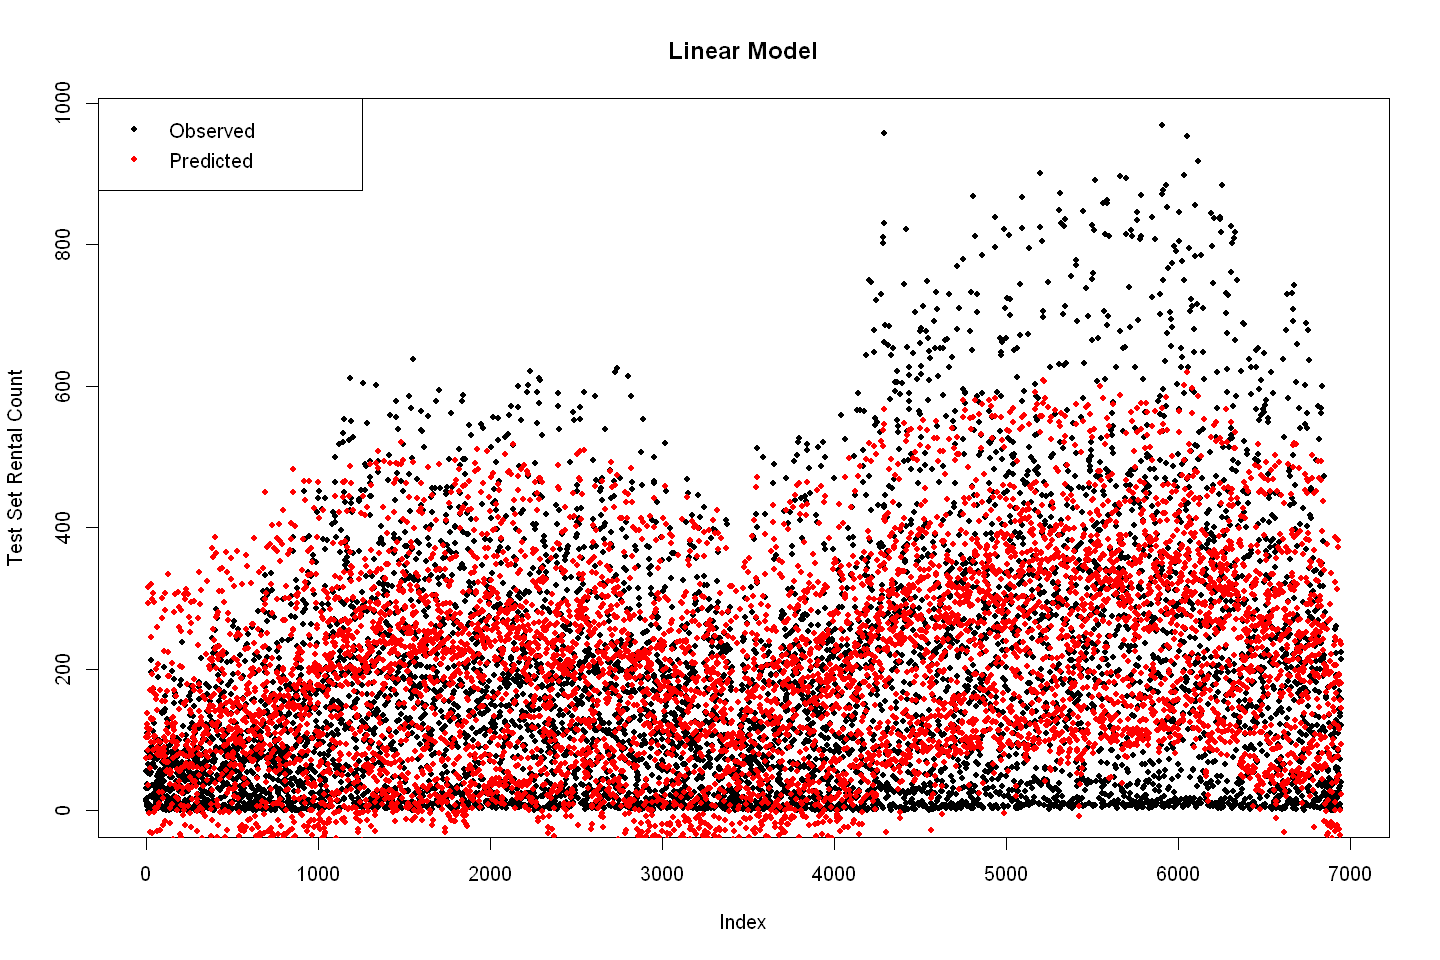

In [16]:
plot(df.test$cnt, main = "Linear Model", ylab = "Test Set Rental Count", pch = 20) # observed values
points(predict(lmmod, newdata = df.test[,-c(8,9)]), col = "red", pch = 20) # predicted values
legend("topleft", legend = c("Observed", "Predicted"), col = c("black", "red"), pch = 20)

### Figure 2

Transforming the response into `log` could help us erdicate some of the problems that we are facing with linear model. We could fit something like:

$ log(cnt) = \sum\limits_{j=1} ^ {p} X_{j}\beta_{j} + \epsilon  $

Transforming the response variable in the Bikeshare data can be helpful in addressing two main issues associated with fitting a linear regression model: the occurrence of negative predictions and the presence of heteroscedasticity in the original data. By transforming the response, we can avoid negative predicted values and reduce heteroscedasticity, resulting in a more accurate and reliable model. While transforming the response variable can address some issues in fitting a linear regression model, it is not entirely satisfactory. This is because the predictions and interpretations are made in terms of the logarithm of the response rather than the response itself, which can be challenging for interpretation. Moreover, this transformation cannot be applied to data sets where the response can take on a value of 0. Therefore, although using a transformation of the response can be a reasonable approach for some count-valued data sets, it may not always be the optimal solution.

The Poisson distribution is commonly employed to model counts due to several reasons, such as the fact that counts, like the Poisson distribution, are restricted to non-negative integer values. This makes it a suitable and natural choice for modeling count data.

## Poisson model

In [ ]:
poismod <- glm(cnt~., data = df[,-c(7,8)], family = poisson)
predpois <- predict(poismod, df.test[,-c(7,8,9)], type="response")
msepois <- mean((df.test[,9] - predpois)^2)
summary(poismod)
BIC(poismod)

### Red dots are predicted values and black ones are original

In [ ]:
plot(df.test$cnt, main = "GLM - Poisson", ylab = "Test Set Rental Count", pch = 20) # observed values
points(predpois, col = "red", pch = 20) # predicted values
legend("topleft", legend = c("Observed", "Predicted"), col = c("black", "red"), pch = 20)

### Figure 3

When using a Poisson regression to model bike usage, we make an implicit assumption that the mean bike usage in an hour is equal to the variance of bike usage during that hour. This is because the Poisson distribution is typically used to model counts, and counts, like the Poisson distribution, take on nonnegative integer values. In contrast, a linear regression model assumes that the variance of bike usage always takes on a constant value. Therefore, the Poisson regression model is better suited to handle the mean-variance relationship observed in the Bikeshare data compared to the linear regression model. In fact from Table 1, we can see that the variance in 'cnt' appears to be much higher than the mean, a situation referred to as "overdispersion" which can seemingly be handled by quasi-poisson model. We checked the results from  a quasi-poisson model as well and the result is the same as that of a Poisson model.

## Cubic model check

In [27]:
mymodel = lm(cnt~ .+ .^2, data = df[,-c(8,9)])# removing 'casual' and 'registered' columns
summary(mymodel)


Call:
lm(formula = cnt ~ . + .^2, data = df[, -c(8, 9)])

Residuals:
    Min      1Q  Median      3Q     Max 
-391.41  -22.41    0.00   22.63  431.75 

Coefficients: (87 not defined because of singularities)
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                            4.033e+01  2.122e+01   1.901 0.057329
seasonspring                           2.765e+01  3.405e+01   0.812 0.416798
seasonsummer                           1.754e+02  4.021e+01   4.363 1.29e-05
seasonfall                             1.620e+01  2.776e+01   0.584 0.559511
yr                                     5.984e+00  8.839e+00   0.677 0.498440
mnthFeb                                8.825e+00  1.884e+01   0.468 0.639469
mnthMar                               -1.842e+01  2.146e+01  -0.859 0.390520
mnthApr                                2.789e+01  4.085e+01   0.683 0.494714
mnthMay                                1.423e+02  4.384e+01   3.245 0.001178
mnthJun              

In [ ]:
step <- stepAIC(mymodel, direction = "both", trace = FALSE)
summary(step)